# Simulated Classical and Quantum Annealing Unfolders

Based on the SVD example taken from [ROOT's TSVDUnfoldExample](https://root.cern/doc/master/TSVDUnfoldExample_8C.html).

In [1]:
# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500, edgeitems=10)
# example imports
import example
from utils import root_utils
# plotting imports
import pylab as plt
%matplotlib inline

Welcome to JupyROOT 6.23/01


In [2]:
# Set up logger to print in the notebook
import sys, logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(
    stream=sys.stdout,
    format="[%(name)s] %(levelname)s: %(message)s",
    level=logging.DEBUG,
)

**IMPORTANT:** set this parameter to `True` if the `SimulatedQuantumAnnealingBackend` is meant to be used. Set to `False` to use the "classical" `SimulatedAnnealingBackend`

In [3]:
# Parameter if (Simulated) Quauntum Annealing should be used vs Simulated Annealing
do_quantum = False

## Initialization
The initial histogram and the response matrix are generated from a Breit-Weigner distribution and the test histograms (to unfold and to fit) are generated from a Gaussian distribution

In [4]:
# toy generation
nbins = 40
# Generate initial distribution and response matrix
xini, bini, Adet = example.maker.generate_initial_samples(nbins)
# Generate test distribution (what is measured in the experiment)
datatrue, data, statcov = example.maker.generate_test_samples(nbins)

Turn into python variables and translate Adetpy from a matrix of events (as used in SVD) to a matrix of probabilities (as required by quantum annealing)

In [5]:
# Map ROOT objects to numpy arrays
xinipy, xinipy_edges = root_utils.histogram_to_python(xini)
binipy, binipy_edges = root_utils.histogram_to_python(bini)
Adetpy_events, Adetpy_edges = root_utils.histogram_to_python(Adet)

# Data
datapy, datapy_edges = root_utils.histogram_to_python(data)
# Data "truth" distribution to test the unfolding
datatruepy, datatruepy_edges = root_utils.histogram_to_python(datatrue)
# Statistical covariance matrix
statcovpy, statcovpy_edges = root_utils.histogram_to_python(statcov)
# Turn Adetpy from number of events to probabilities (to use it with quantum annealing)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

Plot response matrix and histograms

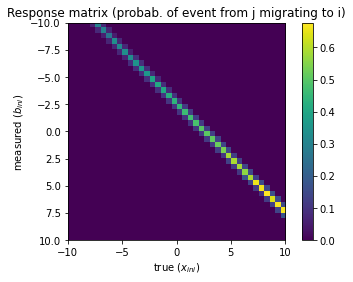

In [6]:
# Show response matrix
left_edge  = xinipy_edges[0][0]
right_edge = xinipy_edges[0][-1]
bottom_edge  = binipy_edges[0][-1]
top_edge = binipy_edges[0][0]
plt.imshow(Adetpy, extent=[left_edge, right_edge, bottom_edge, top_edge])
plt.xlabel("true ($x_{ini}$)")
plt.ylabel("measured ($b_{ini}$)")
plt.title("Response matrix (probab. of event from j migrating to i)")
plt.colorbar()

Text(0.5, 1.0, 'Test distribution')

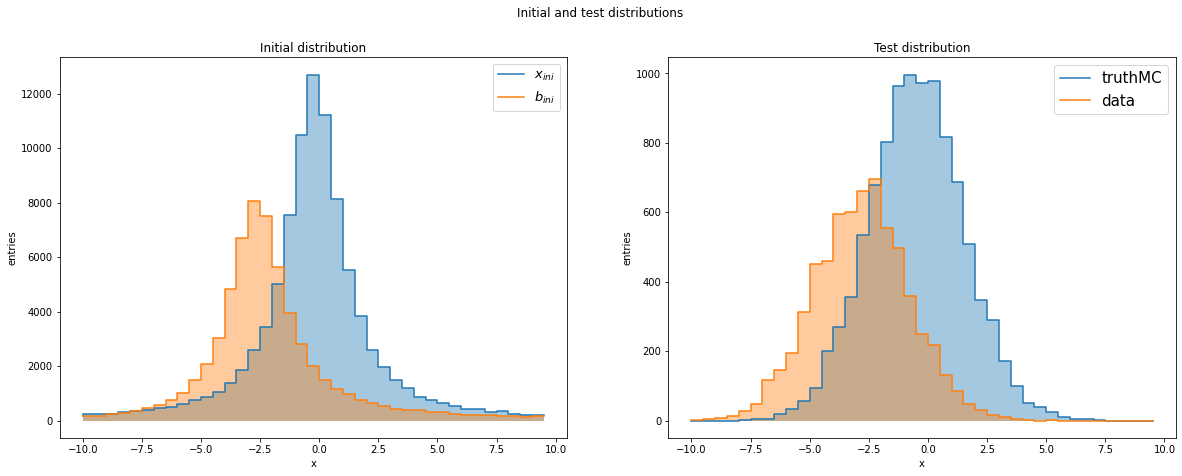

In [7]:
axis = xinipy_edges[0][:-1]

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Initial and test distributions")

"""
Left hand side
"""
# plot x_ini
axs[0].step(axis, xinipy, fillstyle="bottom", label="$x_{ini}$")
axs[0].fill_between(axis, xinipy, step="pre", alpha=0.4)
# plot b_ini
axs[0].step(axis, binipy, fillstyle="bottom", label="$b_{ini}$")
axs[0].fill_between(axis, binipy, step="pre", alpha=0.4)

axs[0].set_xlabel("x")
axs[0].set_ylabel("entries")
axs[0].legend(prop={'size': 13})
axs[0].set_title("Initial distribution")

"""
Right hand side
"""
# plot truth distribution
axs[1].step(axis, datatruepy, fillstyle="bottom", label="truthMC")
axs[1].fill_between(axis, datatruepy, step="pre", alpha=0.4)
# plot what the detector sees
axs[1].step(axis, datapy, fillstyle="bottom", label="data")
axs[1].fill_between(axis, datapy, step="pre", alpha=0.4)

axs[1].set_xlabel("x")
axs[1].set_ylabel("entries")
axs[1].legend(prop={'size': 15})
axs[1].set_title("Test distribution")


## Unfold

In [12]:
# annealing unfolder
from unfolders.annealing import QUBOUnfolder, backends

# Unfold the normal histograms
# adding +1 to avoid division over zero
unfolder_annealing = QUBOUnfolder(
    datatruepy+1, Adetpy, datapy, n_bits=4, weight_regularization=0.5
)
# simulate using a path-integral Monte Carlo approach with the default parameters
annealer = backends.SimulatedQuantumAnnealingBackend(50) if do_quantum else backends.SimulatedAnnealingBackend(50)
x_unfolded = unfolder_annealing.solve(annealer)

[unfolders.annealing.decimal2binary] DEBUG: Encoding: [  1.   1.   1.   1.   1.   2.   5.   5.  20.  33.  56.  95. 201. 270. 358. 534. 678. 802. 964. 997. 972. 978. 817. 688. 509. 349. 289. 173. 100.  51.  39.  25.  11.   4.   4.   2.   1.   1.   1.   1.]
[unfolders.annealing.decimal2binary] DEBUG: - Encoding x[39]=1.0:
[unfolders.annealing.decimal2binary] DEBUG:   - x_d = x[39] - alpha[39] = 1.0 - 0.5 = 0.5
[unfolders.annealing.decimal2binary] DEBUG:   - Beta = [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    

# Plotting results

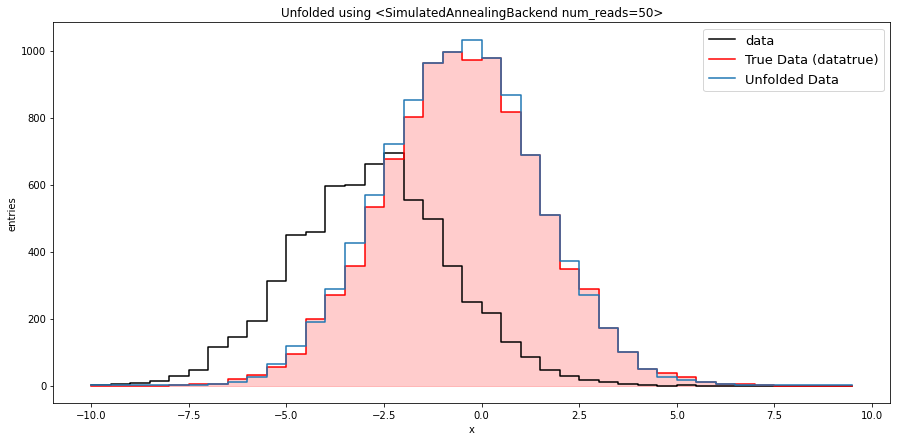

In [13]:
# plot
axis = xinipy_edges[0][:-1]
plt.figure(figsize=(15, 7))

# plot the distribution from which the Response matrix is taken
# plt.step(axis, xinipy, fillstyle="bottom", label="True MC ($x_{ini}$)")
# plt.fill_between(axis, xinipy, step="pre", alpha=0.4)
# plot what was measured
plt.step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
plt.step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
plt.fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
plt.step(axis, x_unfolded, fillstyle="bottom", label="Unfolded Data")

plt.title(f"Unfolded using {annealer}")
plt.xlabel("x")
plt.ylabel("entries")
plt.legend(prop={'size': 13})

# Test goodness of fit (work in progress)
Perform a $\chi^2$ test 

In [19]:
from scipy import stats
statistic, pvalue = stats.chisquare(x_unfolded+5, f_exp=datatruepy+5)
print(f"Chi² resulted with a value={statistic} and p={pvalue}, so as (pvalue > 0.05 = {pvalue > 0.05}), the unfolding is considered {'VALID' if pvalue > 0.05 else 'INVALID'}")

Chi² resulted with a value=53.72755323331195 and p=0.05845359978967044, so as (pvalue > 0.05 = True), the unfolding is considered VALID


In [29]:
# Invert covariance matrix
from numpy.linalg import inv
B_inverse = np.zeros(shape=statcovpy.shape)
for i in range(len(statcovpy)):
    if statcovpy[i][i] != 0:
        B_inverse[i][i] = 1/statcovpy[i][i]

In [31]:
# Compute by-hand
v1 = Adetpy.dot(x_unfolded) - datapy
value = v1.T.dot( B_inverse.dot(v1) )
print(f"Statistics = {value}")
# look for p value
from scipy.stats.distributions import chi2
print(f"p-value = {chi2.sf(value, nbins-1)}")

Statistics = 39.47089463701353
p-value = 0.44883469476835935
